# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

import os, sys, re, gc, joblib
from pathlib import Path
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap

import seaborn as sn

import anndata
import scanpy as sc
import sctk as sk


rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
sk.set_figsize((4, 4))
expr_cmap = sk.expression_colormap()

In [3]:
data_root = Path('/lustre/scratch126/cellgen/team205/nh3/skin').resolve()
proj_root = Path('~/FCA_Fetal_Skin_priv/').expanduser()
os.chdir(proj_root)
!pwd

/home/jovyan/FCA_Fetal_Skin_priv


# Load data

In [4]:
pooled_ad = sc.read(Path(data_root, "20211022_final_figures/h5ad/pooled_fetal_organoid.count_with_annot.h5ad"))

In [5]:
pooled_ad

AnnData object with n_obs × n_vars = 310368 × 46794
    obs: 'dataset', 'donor', 'pcw', 'day', 'sample_id', 'fetal_annot', 'organoid_annot', 'pooled_annot', 'chemistry', 'gender', 'sorting'
    var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'

In [6]:
pooled_ad.X.data

array([5., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [7]:
pooled_ad.obs.pooled_annot.cat.categories.tolist()

['fetal_ASDC',
 'fetal_Adipocytes',
 'fetal_Arterial',
 'fetal_B cell',
 'fetal_Basal',
 'fetal_CD4 T cell',
 'fetal_CD8 T cell',
 'fetal_Capillary (venular tip)',
 'fetal_Capillary/postcapillary venule',
 'fetal_Companion layer',
 'fetal_Cuticle/cortex',
 'fetal_DC1',
 'fetal_DC2',
 'fetal_Dermal condensate',
 'fetal_Dermal papillia',
 'fetal_Early LE',
 'fetal_Early endothelial cell',
 'fetal_Early erythroid',
 'fetal_Early erythroid (embryonic)',
 'fetal_Early myocytes',
 'fetal_Eo/baso/mast cell progenitor',
 'fetal_Erythroid (embryonic)',
 'fetal_Erythroid (fetal)',
 'fetal_FRZB+ early fibroblast',
 'fetal_HOXC5+ early fibroblast',
 'fetal_HSC',
 'fetal_ILC2',
 'fetal_ILC3',
 'fetal_Immature basal',
 'fetal_Immature suprabasal',
 'fetal_Inflammatory DC',
 'fetal_Innate T type1',
 'fetal_Innate T type3',
 'fetal_Inner root sheath',
 'fetal_Iron-recycling macrophage',
 'fetal_LC',
 'fetal_LE',
 'fetal_LMCD1+ mural cell',
 'fetal_LTi',
 'fetal_LYVE1++ macrophage',
 'fetal_Lymphoid pr

# Process

## Subset, split, normalise, etc

In [8]:
pooled_ad.obs.pooled_annot.cat.rename_categories(
    {"organoid_POSTN+ fibroblast": "organoid_WNT2+ fibroblast"}, inplace=True
)

In [9]:
k_included = pooled_ad.obs.pooled_annot.isin(
    [
        "fetal_Basal",
        "fetal_Companion layer",
        "fetal_Cuticle/cortex",
        "fetal_Immature basal",
        "fetal_Immature suprabasal",
        "fetal_Inner root sheath",
        "fetal_Matrix/placode",
        "fetal_Outer root sheath",
        "fetal_Periderm",
        "fetal_POSTN+ basal",
        "fetal_Suprabasal IFE",
        "fetal_FRZB+ early fibroblast",
        "fetal_HOXC5+ early fibroblast",
        "fetal_WNT2+ fibroblast",
        # "fetal_PEAR1+ fibroblast",
        "fetal_Pre-dermal condensate",
        "fetal_Dermal condensate",
        "fetal_Dermal papillia",
        "organoid_Basal",
        "organoid_Companion layer",
        "organoid_Cuticle/cortex",
        "organoid_Immature basal",
        "organoid_Immature suprabasal",
        "organoid_Inner root sheath",
        "organoid_Matrix/placode",
        "organoid_Outer root sheath",
        "organoid_Periderm",
        "organoid_POSTN+ basal",
        "organoid_Suprabasal IFE",
        "organoid_FRZB+ early fibroblast",
        "organoid_HOXC5+ early fibroblast",
        "organoid_WNT2+ fibroblast",
        # "organoid_PEAR1+ fibroblast",
        "organoid_Pre-dermal condensate",
        "organoid_Dermal condensate",
        "organoid_Dermal papillia",
    ]
)

In [10]:
ad1 = pooled_ad[k_included]

In [11]:
ads = sk.split_by_group(ad1, groupby="dataset")

In [12]:
ads

{'fetal': AnnData object with n_obs × n_vars = 90104 × 46794
     obs: 'dataset', 'donor', 'pcw', 'day', 'sample_id', 'fetal_annot', 'organoid_annot', 'pooled_annot', 'chemistry', 'gender', 'sorting'
     var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells',
 'organoid': AnnData object with n_obs × n_vars = 105303 × 46794
     obs: 'dataset', 'donor', 'pcw', 'day', 'sample_id', 'fetal_annot', 'organoid_annot', 'pooled_annot', 'chemistry', 'gender', 'sorting'
     var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'}

In [13]:
for name, ad in ads.items():
    sc.pp.filter_genes(ad, min_counts=1)
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

In [14]:
ads["fetal"].X.data

array([0.43932745, 0.43932745, 0.9764408 , ..., 1.5827801 , 1.5827801 , 1.5827801 ], dtype=float32)

## Extract and prepare data to plot

In [15]:
fetal_genes = ["DSC3", "DSP", "GJB6", "PVRL4"]
organoid_genes = ["DSC3", "DSP", "GJB6", "NECTIN4"]

In [16]:
fetal_x = (
    pd.concat(
        [pd.Series(ads["fetal"].obs_vector(g), index=ads["fetal"].obs_names) for g in fetal_genes],
        axis=1,
    )
    .rename(columns={i: g for i, g in enumerate(fetal_genes)})
    .assign(annot=ads["fetal"].obs.pooled_annot.str.replace("fetal_", ""))
)

In [17]:
fetal_df = (
    fetal_x.melt(id_vars=["annot"], var_name="gene", value_name="expression")
    .groupby(["annot", "gene"])
    .agg(
        mean=pd.NamedAgg(column="expression", aggfunc="mean"),
        frac=pd.NamedAgg(column="expression", aggfunc=lambda x: (x > 0).mean()),
    )
    .reset_index()
    .assign(dataset="fetal")
)

In [18]:
organoid_x = (
    pd.concat(
        [
            pd.Series(ads["organoid"].obs_vector(g), index=ads["organoid"].obs_names)
            for g in organoid_genes
        ],
        axis=1,
    )
    .rename(columns={i: g for i, g in enumerate(organoid_genes)})
    .assign(annot=ads["organoid"].obs.pooled_annot.str.replace("organoid_", ""))
)

In [19]:
organoid_df = (
    organoid_x.melt(id_vars=["annot"], var_name="gene", value_name="expression")
    .groupby(["annot", "gene"])
    .agg(
        mean=pd.NamedAgg(column="expression", aggfunc="mean"),
        frac=pd.NamedAgg(column="expression", aggfunc=lambda x: (x > 0).mean()),
    )
    .reset_index()
    .assign(dataset="organoid")
)

In [20]:
df = pd.concat([fetal_df, organoid_df])

In [21]:
df["gene2"] = df.dataset.astype(str) + " " + df.gene.astype(str)

In [22]:
df["annot"] = df["annot"].astype(
    pd.CategoricalDtype(
        categories=[
            "Periderm",
            "Immature basal",
            "Immature suprabasal",
            "POSTN+ basal",
            "Basal",
            "Suprabasal IFE",
            "Outer root sheath",
            "Companion layer",
            "Inner root sheath",
            "Matrix/placode",
            "Cuticle/cortex",
            "FRZB+ early fibroblast",
            "HOXC5+ early fibroblast",
            "WNT2+ fibroblast",
            # "PEAR1+ fibroblast",
            "Pre-dermal condensate",
            "Dermal condensate",
            "Dermal papillia",
        ],
        ordered=True,
    )
)
df["x"] = df.annot.cat.codes
df["gene2"] = df["gene2"].astype(
    pd.CategoricalDtype(
        categories=[
            "fetal DSC3",
            "organoid DSC3",
            "fetal DSP",
            "organoid DSP",
            "fetal GJB6",
            "organoid GJB6",
            "fetal PVRL4",
            "organoid NECTIN4",
        ],
        ordered=True,
    )
)
df["y"] = df.gene2.cat.codes

In [23]:
df = df.merge(
    df.groupby("gene2")["mean"].max().rename("max_mean"),
    how="left",
    left_on="gene2",
    right_index=True,
)
df["mean2"] = df["mean"] / df["max_mean"]

In [24]:
df.annot.cat.categories

Index(['Periderm', 'Immature basal', 'Immature suprabasal', 'POSTN+ basal',
       'Basal', 'Suprabasal IFE', 'Outer root sheath', 'Companion layer',
       'Inner root sheath', 'Matrix/placode', 'Cuticle/cortex',
       'FRZB+ early fibroblast', 'HOXC5+ early fibroblast', 'WNT2+ fibroblast',
       'Pre-dermal condensate', 'Dermal condensate', 'Dermal papillia'],
      dtype='object')

In [25]:
df.head()

,annot,gene,mean,frac,dataset,gene2,x,y,max_mean,mean2
0,Basal,DSC3,0.500099,0.557055,fetal,fetal DSC3,4,0,2.148966,0.232716
1,Basal,DSP,1.120920,0.869939,fetal,fetal DSP,4,2,3.022784,0.370824
2,Basal,GJB6,1.486292,0.883436,fetal,fetal GJB6,4,4,1.611308,0.922413
3,Basal,PVRL4,0.025657,0.040491,fetal,fetal PVRL4,4,6,1.557022,0.016478
4,Companion layer,DSC3,1.560662,0.777778,fetal,fetal DSC3,7,0,2.148966,0.726239


## Plot

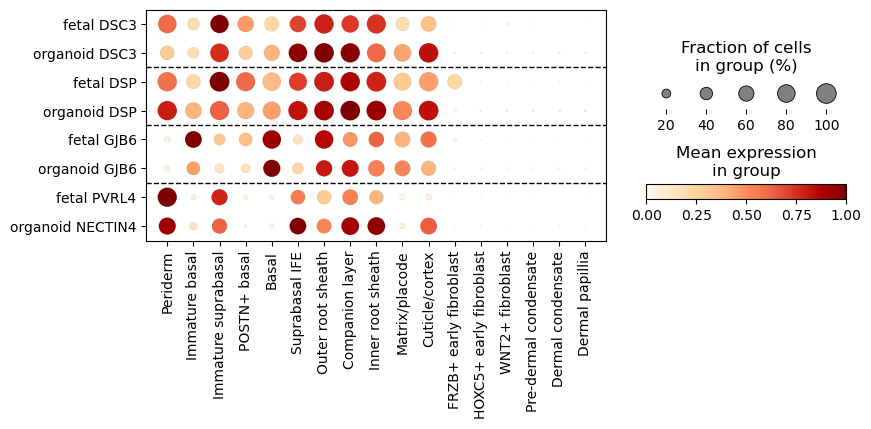

In [26]:
sk.set_figsize((8, 3))

# Main axes
ax = sn.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="mean2",
    size="frac",
    palette="OrRd",
    edgecolor="k",
    sizes=(0, 200),
    legend=False,
)
ax.set_xticks(np.arange(17))
ax.set_xticklabels(df.annot.cat.categories, rotation=90)
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_yticklabels(df.gene2.cat.categories)
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
ax.set_ylim(7.5, -0.5)
for ypos in (1.5, 3.5, 5.5):
    ax.axhline(y=ypos, linewidth=1, c="k", linestyle="--")
ax.set_xlabel("")
ax.set_ylabel("")

# Make legend
fig = ax.get_figure()
fig.subplots_adjust(right=0.7)

# Dot size legend
dlg_ax = fig.add_axes([0.75, 0.55, 0.25, 0.1])
sn.scatterplot(
    x=[20, 40, 60, 80, 100],
    y=[0, 0, 0, 0, 0],
    size=[20, 40, 60, 80, 100],
    sizes=(40, 200),
    color=[(0.5, 0.5, 0.5)],
    edgecolor="black",
    ax=dlg_ax,
    legend=False,
)
sn.despine(ax=dlg_ax, left=True, bottom=True)
dlg_ax.get_yaxis().set_visible(False)
dlg_ax.set_xticks([20, 40, 60, 80, 100])
dlg_ax.set_xlim(10, 110)
dlg_ax.set_title("Fraction of cells\nin group (%)")

# Colorbar
cb_ax = fig.add_axes([0.75, 0.25, 0.25, 0.05])
cb_ax.set_title("Mean expression\nin group")
fig.colorbar(
    plt.cm.ScalarMappable(
        cmap="OrRd",
    ),
    cax=cb_ax,
    orientation="horizontal",
)
sn.despine(ax=cb_ax, left=True, bottom=True)
cb_ax.get_yaxis().set_visible(False)

In [27]:
fig.savefig("figures/final/figS2M.20220920.pdf", bbox_inches="tight")